
0: 384x640 1 cadiz, 1 real-madrid, 101.0ms
Speed: 3.3ms preprocess, 101.0ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


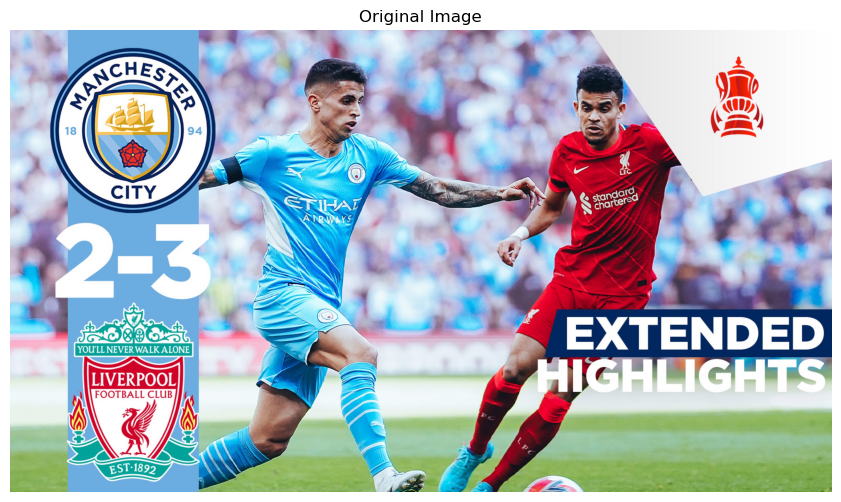

In [3]:
from ultralytics import YOLO
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Load YOLOv8 segmentation model
model = YOLO("streamlitapp/Models/best.pt")  # Replace with your model path

# Load image
image_path = "image.jpg"  # Replace with your image path
image = Image.open(image_path).convert("RGB")
image_np = np.array(image)

# Run inference
results = model(image_np)

# Extract segmentation masks
segmented_objects = []
for result in results:
    if result.masks is None:
        continue  # Skip if no mask detected

    masks = result.masks.data.cpu().numpy()  # Convert to NumPy array
    
    for mask in masks:
        mask = (mask * 255).astype(np.uint8)  # Convert to 0-255 range
        mask = cv2.resize(mask, (image_np.shape[1], image_np.shape[0]))  # Resize to original image size

        # Apply mask to image
        segmented = cv2.bitwise_and(image_np, image_np, mask=mask)
        segmented_objects.append(segmented)

# Display results
plt.figure(figsize=(12, 6))
plt.subplot(1, len(segmented_objects) + 1, 1)
plt.imshow(image_np)
plt.title("Original Image")
plt.axis("off")

for i, obj in enumerate(segmented_objects):
    plt.subplot(1, len(segmented_objects) + 1, i + 2)
    plt.imshow(obj)
    plt.title(f"Object {i+1}")
    plt.axis("off")

plt.show()


In [4]:
import torch
import cv2
import numpy as np
from ultralytics import YOLO
from PIL import Image

# Load YOLO model
model = YOLO("streamlitapp/Models/best.pt")  # Update with your model path

# Load image
image_path = "Covers_Doku-article-1512-1.png"  # Replace with your image path
image = cv2.imread(image_path)
print(image)
# Perform inference
results = model(image)

# Store cropped object images
object_images = []

for result in results:
    boxes = result.boxes.xyxy.cpu().numpy()  # Extract bounding boxes

    for (x1, y1, x2, y2) in boxes:
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

        # Crop the detected object
        cropped_object = image[y1:y2, x1:x2]

        # Apply GrabCut to remove background
        mask = np.zeros(cropped_object.shape[:2], np.uint8)
        bgd_model = np.zeros((1, 65), np.float64)
        fgd_model = np.zeros((1, 65), np.float64)
        rect = (5, 5, cropped_object.shape[1] - 10, cropped_object.shape[0] - 10)
        cv2.grabCut(cropped_object, mask, rect, bgd_model, fgd_model, 5, cv2.GC_INIT_WITH_RECT)

        mask = np.where((mask == 2) | (mask == 0), 0, 1).astype(np.uint8)
        object_no_bg = cropped_object * mask[:, :, np.newaxis]

        # Convert to RGBA (add alpha channel for transparency)
        obj_img = Image.fromarray(cv2.cvtColor(object_no_bg, cv2.COLOR_BGR2RGB)).convert("RGBA")

        # Create alpha mask from the segmentation
        alpha = Image.fromarray((mask * 255).astype(np.uint8), mode="L")
        obj_img.putalpha(alpha)

        object_images.append(obj_img)

# Combine images side by side
if object_images:
    widths, heights = zip(*(img.size for img in object_images))
    total_width = sum(widths)
    max_height = max(heights)

    combined_image = Image.new("RGBA", (total_width, max_height), (255, 255, 255, 0))  # Transparent background
    x_offset = 0
    for img in object_images:
        combined_image.paste(img, (x_offset, 0), img.split()[3])  # Use alpha channel as mask
        x_offset += img.width

    # Save and display
    combined_image.save("combined_objects.png")
    combined_image.show()


[[[10  9  7]
  [10  9  7]
  [10  9  7]
  ...
  [12 11 10]
  [12 11 10]
  [12 11 10]]

 [[10  9  7]
  [10  9  7]
  [10  9  7]
  ...
  [12 11 10]
  [12 11 10]
  [12 11 10]]

 [[10  9  7]
  [10  9  7]
  [10  9  7]
  ...
  [12 11 10]
  [12 11 10]
  [12 11 10]]

 ...

 [[10  9  7]
  [10  9  7]
  [10  9  7]
  ...
  [18 22 22]
  [18 22 22]
  [18 22 22]]

 [[10  9  7]
  [10  9  7]
  [10  9  7]
  ...
  [18 22 22]
  [18 22 22]
  [18 22 22]]

 [[10  9  7]
  [10  9  7]
  [10  9  7]
  ...
  [18 22 22]
  [18 22 22]
  [18 22 22]]]

0: 384x640 1 arsenal, 1 manchester city, 209.6ms
Speed: 6.1ms preprocess, 209.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
